# Clonamos el repositorio para obtener los dataSet

In [1]:
!git clone https://github.com/joanby/tensorflow.git

Cloning into 'tensorflow'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 60311 (delta 32), reused 37 (delta 23), pack-reused 60260
Receiving objects: 100% (60311/60311), 442.46 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (60225/60225), done.


# Damos acceso a nuestro Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Test it

In [ ]:
!ls '/content/drive/My Drive' 

# Google colab tools

In [ ]:
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador
from google.colab import drive # Montar tu Google drive

##Especificando la versión de TensorFlow

Ejecutando "importar tensorflow" importará la versión por defecto (actualmente 2.x). Puedes usar la 1.x ejecutando una celda con la "versión mágica de tensorflow" **antes de ejecutar "importar tensorflow".

### Si no funciona hacer el pip install


In [3]:
#!pip install tensorflow==1.14
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Importar Tensorflow

In [51]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

1.15.2


In [52]:
session = tf.Session()

# Regresión logística

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from sklearn.preprocessing import normalize

In [54]:
url = "https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.dat?token=AMRAeMNwZBLC86UzdMdxEuhlGPMufKa5ks5cVIdzwA%3D%3D"
birth_file = requests.get(url)
birth_data = birth_file.text.split('\r\n')

birth_header = birth_data[0].split('\t')
birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]

In [55]:
import os.path
import csv

birthweight_file_name = "/content/tensorflow/datasets/birthweight.csv"
if not os.path.exists(birthweight_file_name):
    with open(birthweight_file_name, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        f.close()

In [56]:
birth_data = []
with open(birthweight_file_name, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

In [57]:
birth_header

['LOW', 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI', 'BWT']

In [58]:
birth_data[0]

['1.0', '28.0', '113.0', '1.0', '1.0', '1.0', '0.0', '1.0', '709.0']

In [59]:
birth_data = [[float(x) for x in row] for row in birth_data]

In [60]:
birth_data[0]

[1.0, 28.0, 113.0, 1.0, 1.0, 1.0, 0.0, 1.0, 709.0]

In [61]:
y_vals = np.array([x[0] for x in birth_data])
x_vals = np.array([x[1:8] for x in birth_data])

### Dividir en entrenamiento y test

In [62]:
train_idx =np.random.choice(len(x_vals), size=round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

In [63]:
x_vals_train = x_vals[train_idx]
y_vals_train = y_vals[train_idx]

x_vals_test = x_vals[test_idx]
y_vals_test = y_vals[test_idx]

### Normalización

In [64]:
def normalize_cols(m, col_min = np.array([None]), col_max=np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return (m-col_min)/(col_max-col_min), col_min, col_max

In [65]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))

In [66]:
x_vals_train[0]

array([0.40909091, 0.78676471, 1.        , 1.        , 0.        ,
       0.        , 0.        ])

In [67]:
train_min

array([14., 80.,  0.,  0.,  0.,  0.,  0.])

In [68]:
train_max 

array([ 36., 216.,   1.,   1.,   1.,   1.,   1.])

In [69]:
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test, col_min=train_min, col_max=train_max))

### Modelo de regresión logística

- $x \in \mathbb R^7$
- $A \in \mathbb R_{7\times 1}$
- $b \in \mathbb R$
- $y = Ax+b\in \mathbb R$
- $\hat{y} = sigmoid(y)\in (0,1) $

In [70]:
batch_size = 25
x_data = tf.placeholder(shape=[None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[7,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
y_pred = tf.add(tf.matmul(x_data, A), b)

In [71]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels= y_target))
init = tf.global_variables_initializer()
session.run(init)
my_optim = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_step = my_optim.minimize(loss)

In [72]:
classification_lr = tf.round(tf.sigmoid(y_pred))
correct_classification = tf.cast(tf.equal(classification_lr, y_target), tf.float32)
accuracy = tf.reduce_mean(correct_classification)

In [73]:
loss_vec = []
train_acc = []
test_acc = []
for i in range(2000):
    rand_idx = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_idx]
    rand_y = np.transpose([y_vals_train[rand_idx]])
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = session.run(accuracy, 
                                 feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = session.run(accuracy, 
                                feed_dict={x_data: x_vals_test[0], y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if(i+1)%100==0:
        print("Loss: "+str(temp_loss))

Loss: 0.5465503
Loss: 0.71014816
Loss: 0.5814389
Loss: 0.66572195
Loss: 0.603824
Loss: 0.630647
Loss: 0.5895803
Loss: 0.6444476
Loss: 0.53522295
Loss: 0.58255225
Loss: 0.63940024
Loss: 0.58640754
Loss: 0.54262817
Loss: 0.5233861
Loss: 0.692682
Loss: 0.605213
Loss: 0.51437473
Loss: 0.64759517
Loss: 0.5571482
Loss: 0.71908236


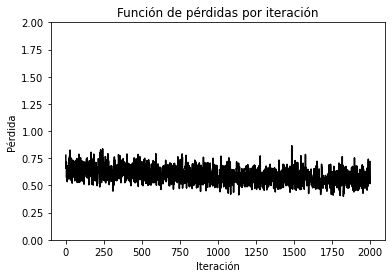

In [74]:
plt.plot(loss_vec, 'k-')
plt.title("Función de pérdidas por iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdida")
plt.ylim([0,2])
plt.show()

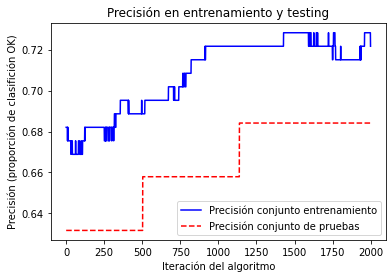

In [75]:
plt.plot(train_acc, 'b-', label = "Precisión conjunto entrenamiento")
plt.plot(test_acc, 'r--', label = "Precisión conjunto de pruebas")
plt.title("Precisión en entrenamiento y testing")
plt.xlabel("Iteración del algoritmo")
plt.ylabel("Precisión (proporción de clasifición OK)")
plt.legend(loc = 'lower right')
plt.show()